In [1]:
import numpy as np
import pandas as pd

from astropy.timeseries import LombScargle
from astropy import units as unt
from astropy.io import fits
from astropy.time import Time

In [2]:
import matplotlib.pyplot as plt

In [3]:
from matplotlib.colors import LogNorm, Normalize

In [4]:
import seaborn as sns
sns.set(style="ticks", palette="muted", rc={"xtick.bottom" : True, "ytick.left" : True})
#plt.style.use('figs/thinfig')
red = "#CA0020"
orange = "#F97100" 
blue = "#0571b0"

In [5]:
# Open the FITS file
filename = "allsites-alldata-waverage-fill.fits"
with fits.open(filename) as hdul:

    # Print general information about the file
    hdul.info()

    # Access the primary header and print its content
    primary_header = hdul[0].header
    print("\nPrimary header:")
    print(primary_header)

    # Access the primary data (if it exists) and print its shape
    primary_data = hdul[0].data
    if primary_data is not None:
        print("\nPrimary data shape:")
        print(primary_data.shape)

    # Access and print information about additional HDUs (if any)
    for idx, hdu in enumerate(hdul[1:], start=1):
        print(f"\nHDU {idx} header:")
        print(hdu.header)
        print(f"\nHDU {idx} data shape:")
        print(hdu.data.shape)

Filename: allsites-alldata-waverage-fill.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      15   (2, 34909918)   float64   

Primary header:
SIMPLE  =                    T / Written by IDL:  Mon Apr  6 14:01:06 2020      BITPIX  =                  -64 /Real*8 (double precision)                       NAXIS   =                    2 /                                                NAXIS1  =                    2 /                                                NAXIS2  =             34909918 /                                                D-START =        2442778.50000 /Data start (Julian)                             D-END   =        2458940.50000 /Data end (Julian)                               STATIONS= 'na ca cb su iz la mo ha' /Stations Used                              METHOD  = 'waverage'           /Overlap Method                                  CADENCE = '40      '           /Timeseries Cadence                              N-THRE

In [6]:
hdul = fits.open(filename)

Remove all data before Jan 1, 1985 and assume 0.01 m/s uncertainty 

In [7]:
date = "1985-01-01"
time_obj = Time(date, format='iso', scale='utc')
jd = time_obj.jd

print(f"The Julian Date for {date} is: {jd}")

The Julian Date for 1985-01-01 is: 2446066.5


In [26]:
time = hdul[0].data[:,0]
rv = hdul[0].data[:,1]
err = 0.01

idx = time>jd
time = time[idx]
rv = rv[idx]

In [27]:
idx = (time > 2.458e6) & (time <= 2.458e6 + 2 * 365.25)
ls = LombScargle(time[idx] * unt.day, rv[idx] * unt.m / unt.s)
frequency, power = ls.autopower()

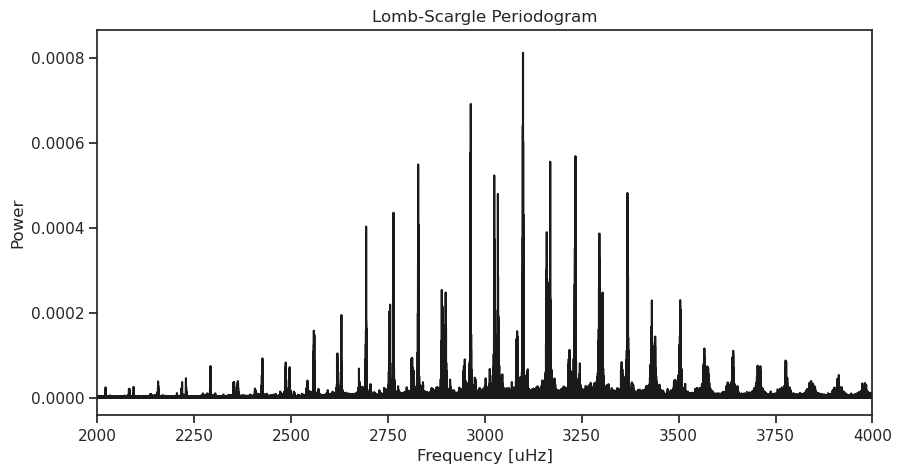

In [28]:
# Plot the periodogram
plt.figure(figsize=(10, 5))
plt.plot(frequency.to(unt.Hz)*1e6, power, 'k-')
plt.xlabel('Frequency [uHz]')
plt.ylabel('Power')
plt.title('Lomb-Scargle Periodogram')
#plt.semilogy()
#plt.ylim([1e-5, 1e-2])
#plt.xlim([2800, 4000])
plt.xlim([2000, 4000])
#plot_both()
#plt.axhline(ls.false_alarm_level(0.05), ls='--', c='red', label=r'$p < 0.05$')
plt.show()

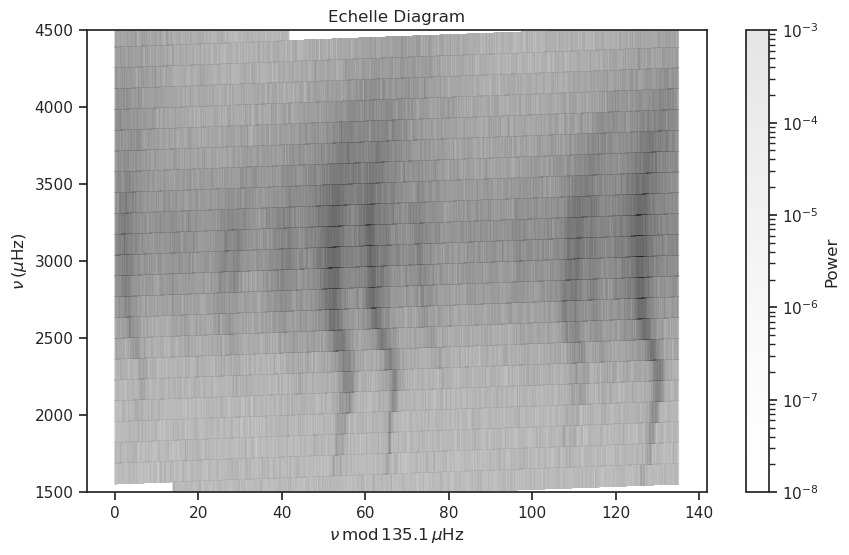

In [29]:
frequency_microHz = frequency.to(unt.microhertz).value
large_separation = 135.1  # in microHertz

idx = np.logical_and(frequency_microHz > 1500, frequency_microHz < 4500, power > 1e-8)
echelle_x = np.mod(frequency_microHz[idx], large_separation)
echelle_y = frequency_microHz[idx]

plt.figure(figsize=(10, 6))
plt.scatter(echelle_x, echelle_y, cmap='Greys', marker="|", linewidths=0.05, s=250, alpha=0.1, c=power.value[idx],
           norm=LogNorm(vmin=1e-8, vmax=1e-3))
plt.colorbar(label='Power')

plt.xlabel(r'$\nu \, \mathrm{mod} \, 135.1 \, \mu\mathrm{Hz}$')
plt.ylabel(r'$\nu \, (\mu\mathrm{Hz})$')

plt.ylim([1500, 4500])

plt.title('Echelle Diagram')
plt.show()

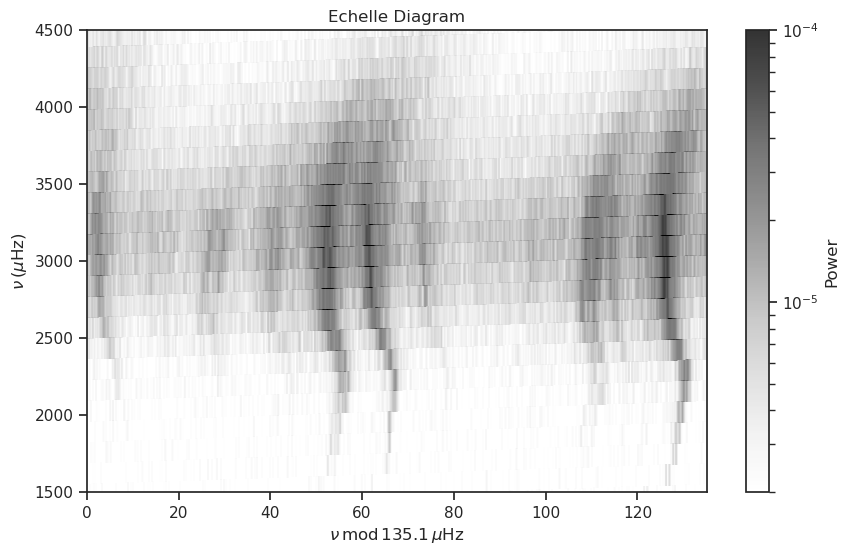

In [30]:
frequency_microHz = frequency.to(unt.microhertz).value
large_separation = 135.1

idx = np.logical_and(frequency_microHz > 1400, frequency_microHz < 4600, power > 1e-8)
sorted_indices = np.argsort(power.value[idx])
echelle_x = np.mod(frequency_microHz[idx], large_separation)[sorted_indices]
echelle_y = frequency_microHz[idx][sorted_indices]
sorted_power = power.value[idx][sorted_indices]

plt.figure(figsize=(10, 6))
plt.scatter(echelle_x, echelle_y, cmap='Greys', marker="|", linewidths=0.01, s=240, alpha=0.8, c=sorted_power,
            norm=LogNorm(vmin=2e-6, vmax=1e-4, clip=True))
plt.colorbar(label='Power')

plt.xlabel(r'$\nu \, \mathrm{mod} \, 135.1 \, \mu\mathrm{Hz}$')
plt.ylabel(r'$\nu \, (\mu\mathrm{Hz})$')

plt.xlim([0, 135.1])
plt.ylim([1500, 4500])

plt.title('Echelle Diagram')
plt.show()

In [31]:
mdl = pd.read_csv('m3_corr2.csv')
mdS = pd.read_csv('mS_corr.csv')
mdl

,E_norm,Re(freq),Im(freq),l,n_g,n_p,n_pg
0,3.302230e-05,825.427833,0.0,0,0,5,5
1,1.270291e-05,972.816912,0.0,0,0,6,6
2,5.391689e-06,1118.249927,0.0,0,0,7,7
3,2.326177e-06,1263.721199,0.0,0,0,8,8
4,1.032452e-06,1407.779124,0.0,0,0,9,9
...,...,...,...,...,...,...,...
189,8.778648e-09,4037.743037,0.0,3,10,27,17
190,6.495475e-01,4125.831773,0.0,3,9,27,18
191,9.021598e-09,4175.108692,0.0,3,9,28,19
192,9.378483e-09,4312.782767,0.0,3,9,29,20


In [32]:
mdl['nu'] = mdl['Re(freq)']
mdS['nu'] = mdS['Re(freq)']

In [33]:
bison = pd.read_csv('bison-lowl-modes.csv')

In [34]:
#mdl = pd.read_csv('data/theoretical-modes.csv')
bison = pd.read_csv('bison-lowl-modes.csv')

def plot_model():
    for mode in mdl.iterrows():
        color = ['gray', 'blue', 'red', 'orange'][int(mode[1].l)]
        plt.axvline(mode[1].nu, ls='--' if mode[1].n_g == 0 else ':', c=color, zorder=-99, alpha=0.5, lw=1)

def plot_bison():
    for mode in bison.iterrows():
        color = ['gray', 'blue', 'red', 'orange'][int(mode[1].l)]
        plt.axvline(mode[1].nu, ls='-', lw=4, c=color, zorder=-98, alpha=0.1)

def plot_both():
    plot_model()
    plot_bison()

def plot_model_P():
    for mode in mdl.iterrows():
        if mode[1].l != 1:
            continue 
        color = ['gray', 'blue', 'red', 'orange'][int(mode[1].l)]
        nu = mode[1].nu * (1e-6*unt.Hz)
        P = (1/nu).to(unt.min)
        plt.axvline(P.value, ls='--' if mode[1].n_g == 0 else ':', c=color, zorder=-99)

def plot_bison_P():
    for mode in bison.iterrows():
        nu = mode[1].nu * (1e-6*unt.Hz)
        P = (1/nu).to(unt.min)
        color = ['gray', 'blue', 'red', 'orange'][int(mode[1].l)]
        plt.axvline(P.value, ls='-', lw=4, c=color, zorder=-98)

def plot_both_P():
    plot_model_P()
    plot_bison_P()

In [35]:
def normalize_part(arr, old_min, old_max, new_min, new_max):
    return (arr - old_min) / (old_max - old_min) * (new_max - new_min) + new_min

def scale_E_norm(df, column, split_value, lower_scaled_min, lower_scaled_max, upper_scaled_min, upper_scaled_max):
    # Calculate 1/np.log(E_norm)
    df['E_log_inv'] = 1 / np.log(df[column])
    
    # Split the data
    lower_part = df[df[column] <= split_value]
    upper_part = df[df[column] > split_value]
    
    # Normalize each part
    lower_part['E_scaled'] = normalize_part(
        lower_part['E_log_inv'], 
        np.min(lower_part['E_log_inv']), 
        np.max(lower_part['E_log_inv']), 
        lower_scaled_min, 
        lower_scaled_max
    )
    
    upper_part['E_scaled'] = normalize_part(
        upper_part['E_log_inv'], 
        np.min(upper_part['E_log_inv']), 
        np.max(upper_part['E_log_inv']), 
        upper_scaled_min, 
        upper_scaled_max
    )
    
    # Combine the results
    result = pd.concat([lower_part, upper_part]).sort_index()
    
    # Drop the temporary column
    result.drop(columns=['E_log_inv'], inplace=True)
    
    return result

split_value = 5e-7
lower_scaled_min = 5e-6
lower_scaled_max = 5e-4 #(1e-3 + 5e-6) / 2
upper_scaled_min = 5e-4 #(1e-3 + 5e-6) / 2
upper_scaled_max = 10e-9

mdl = scale_E_norm(mdl, 'E_norm', split_value, lower_scaled_min, lower_scaled_max, upper_scaled_min, upper_scaled_max)
mdS = scale_E_norm(mdS, 'E_norm', split_value, lower_scaled_min, lower_scaled_max, upper_scaled_min, upper_scaled_max)
mdl

/tmp/ipykernel_262344/1754616394.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  lower_part['E_scaled'] = normalize_part(
/tmp/ipykernel_262344/1754616394.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  upper_part['E_scaled'] = normalize_part(
/tmp/ipykernel_262344/1754616394.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

,E_norm,Re(freq),Im(freq),l,n_g,n_p,n_pg,nu,E_scaled
0,3.302230e-05,825.427833,0.0,0,0,5,5,825.427833,0.000050
1,1.270291e-05,972.816912,0.0,0,0,6,6,972.816912,0.000050
2,5.391689e-06,1118.249927,0.0,0,0,7,7,1118.249927,0.000049
3,2.326177e-06,1263.721199,0.0,0,0,8,8,1263.721199,0.000049
4,1.032452e-06,1407.779124,0.0,0,0,9,9,1407.779124,0.000049
...,...,...,...,...,...,...,...,...,...
189,8.778648e-09,4037.743037,0.0,3,10,27,17,4037.743037,0.000497
190,6.495475e-01,4125.831773,0.0,3,9,27,18,4125.831773,0.000096
191,9.021598e-09,4175.108692,0.0,3,9,28,19,4175.108692,0.000494
192,9.378483e-09,4312.782767,0.0,3,9,29,20,4312.782767,0.000491


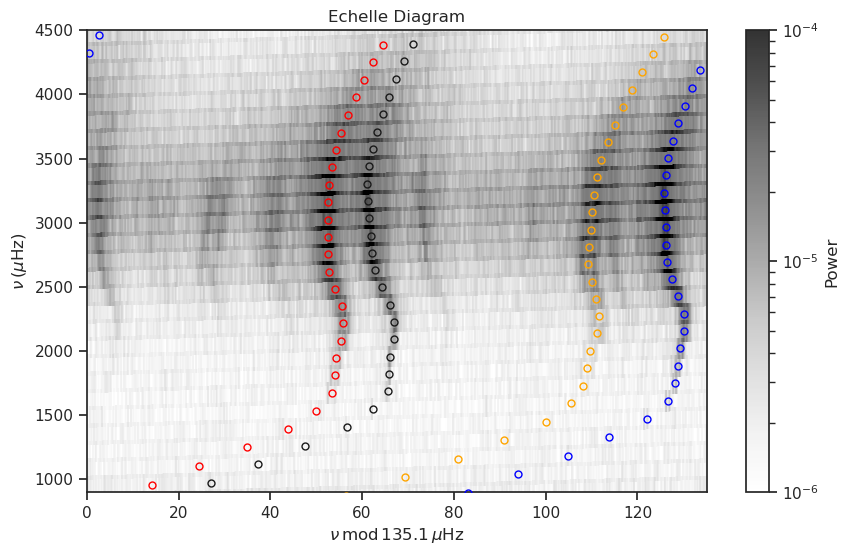

In [36]:
frequency_microHz = frequency.to(unt.microhertz).value
large_separation = 135.1

idx = np.logical_and(frequency_microHz > 800, frequency_microHz < 4600, power > 1e-8)
sorted_indices = np.argsort(power.value[idx])
echelle_x = np.mod(frequency_microHz[idx], large_separation)[sorted_indices]
echelle_y = frequency_microHz[idx][sorted_indices]
sorted_power = power.value[idx][sorted_indices]

plt.figure(figsize=(10, 6))
plt.scatter(echelle_x, echelle_y, cmap='Greys', marker="|", linewidths=0.01, s=240, alpha=0.8, c=sorted_power,
            norm=LogNorm(vmin=1e-6, vmax=1e-4, clip=True), zorder=-999)
plt.colorbar(label='Power')

for mode in mdS.iterrows():
    if mode[1].l > 3:
        continue
    color = ['k', 'blue', 'red', 'orange'][int(mode[1].l)]
    plt.plot(mode[1].nu % 135.1, mode[1].nu, 'o', mfc='None', mew=1, ms=5,
             c=color, zorder=99, alpha=1)

plt.xlabel(r'$\nu \, \mathrm{mod} \, 135.1 \, \mu\mathrm{Hz}$')
plt.ylabel(r'$\nu \, (\mu\mathrm{Hz})$')

plt.xlim([0, 135.1])
plt.ylim([900, 4500])

plt.title('Echelle Diagram')
plt.show()

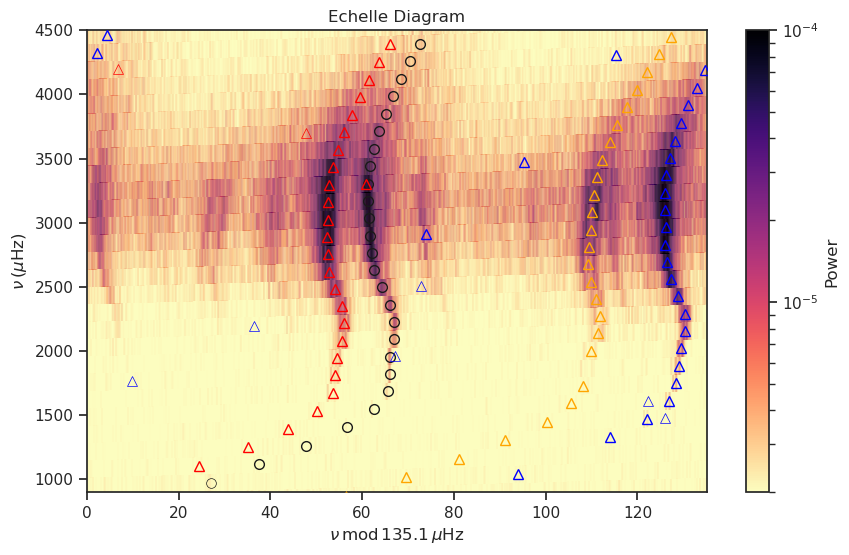

In [67]:
frequency_microHz = frequency.to(unt.microhertz).value
large_separation = 135.1

idx = np.logical_and(frequency_microHz > 800, frequency_microHz < 4600, power > 1e-8)
sorted_indices = np.argsort(power.value[idx])
echelle_x = np.mod(frequency_microHz[idx], large_separation)[sorted_indices]
echelle_y = frequency_microHz[idx][sorted_indices]
sorted_power = power.value[idx][sorted_indices]

plt.figure(figsize=(10, 6))
plt.scatter(echelle_x, echelle_y, cmap='magma_r', marker="|", linewidths=0.025, s=160, alpha=1, c=sorted_power,
            norm=LogNorm(vmin=2e-6, vmax=1e-4, clip=True), zorder=-999)
plt.colorbar(label='Power')


for mode in mdl.iterrows():
    if mode[1].l > 3:
        continue
    if mode[1].E_norm > 1e-3:
        continue
    color = ['k', 'blue', 'red', 'orange'][int(mode[1].l)]
    plt.plot(mode[1].nu % 135.1, mode[1].nu, 'o' if mode[1].n_g == 0 else "^", mfc='None', mew=1 if mode[1].E_norm < 1e-5 else 0.5, ms=7,
             c=color, zorder=99, alpha=1)
#"""

"""
for mode in bison.iterrows():
    nu = mode[1].nu * (1e-6*unt.Hz)
    P = (1/nu).to(unt.min)
    color = ['k', 'blue', 'red', 'orange'][int(mode[1].l)]
    plt.plot(mode[1].nu % 135.1, mode[1].nu, '.', ms=5, zorder=999, c=color)
    #plt.axvline(P.value, ls='-', lw=4, c=color, zorder=-98)
"""

plt.xlabel(r'$\nu \, \mathrm{mod} \, 135.1 \, \mu\mathrm{Hz}$')
plt.ylabel(r'$\nu \, (\mu\mathrm{Hz})$')

plt.xlim([0, 135.1])
plt.ylim([900, 4500])

plt.title('Echelle Diagram')
plt.show()